<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_detection_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Transfer Learning (VGG16)

other models will be mentioned in report and presentation but this works best

80_20_split train_test

## imports

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2


from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data Preprocessing

80_20 train_test_split

batch size 16 gives best result

In [84]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)

train_dir = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/train/'
test_dir  = '/content/drive/MyDrive/Dataset_2/DL_models_dataset/transfer_learning_224x224/80_20/test/'

### Dataset_creation

In [85]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 202 files belonging to 2 classes.


In [86]:
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 51 files belonging to 2 classes.


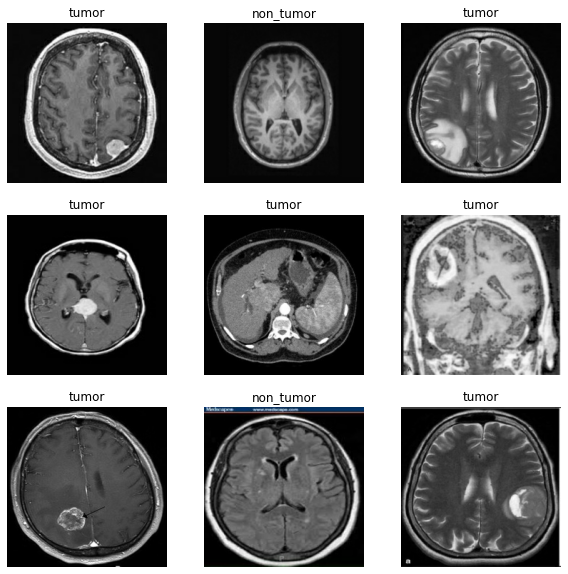

In [87]:
#Show the first nine images and labels from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configuring the dataset performance

In [88]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [89]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

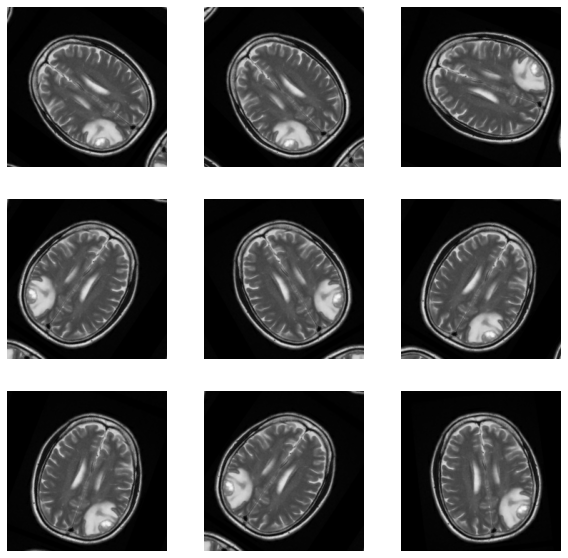

In [90]:
#repeatedly applying augmentation to the same image
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescale pixel values

In [91]:
preprocess_input =  tf.keras.applications.vgg16.preprocess_input

## Create the base model from the pre-trained convnets

In [92]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.efficientnet import EfficientNetB7 as tl_model

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tl_model(weights= 'imagenet', input_tensor= Input(shape = IMG_SHAPE), include_top= False)

258080768/258076736 [==============================] - 2s 0us/step


In [93]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2560)


## Feature extraction

### Freeze the convolutional base

In [94]:
base_model.trainable = False

In [95]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

### Add a classification head

In [96]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2560)


In [97]:
prediction_layer = tf.keras.layers.Dense(1)

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [98]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [99]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [100]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [101]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 2560)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0   

In [102]:
len(model.trainable_variables)

2

### Train the model

In [103]:
initial_epochs = 250

loss0, accuracy0 = model.evaluate(train_dataset)

13/13 [==============================] - 9s 273ms/step - loss: 0.6763 - accuracy: 0.4851


In [104]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.49


In [105]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [106]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=[early_stopping])

Epoch 1/250
13/13 [==============================] - 18s 196ms/step - loss: 0.6178 - accuracy: 0.6139
Epoch 2/250
13/13 [==============================] - 3s 196ms/step - loss: 0.5070 - accuracy: 0.7574
Epoch 3/250
13/13 [==============================] - 3s 196ms/step - loss: 0.4284 - accuracy: 0.8317
Epoch 4/250
13/13 [==============================] - 3s 198ms/step - loss: 0.4054 - accuracy: 0.7970
Epoch 5/250
13/13 [==============================] - 3s 198ms/step - loss: 0.3748 - accuracy: 0.8069
Epoch 6/250
13/13 [==============================] - 3s 198ms/step - loss: 0.3508 - accuracy: 0.8416
Epoch 7/250
13/13 [==============================] - 3s 197ms/step - loss: 0.3409 - accuracy: 0.8663
Epoch 8/250
13/13 [==============================] - 3s 197ms/step - loss: 0.3482 - accuracy: 0.8465
Epoch 9/250
13/13 [==============================] - 3s 197ms/step - loss: 0.3076 - accuracy: 0.8812
Epoch 10/250
13/13 [==============================] - 3s 195ms/step - loss: 0.3099 - accur

### Learning Curves

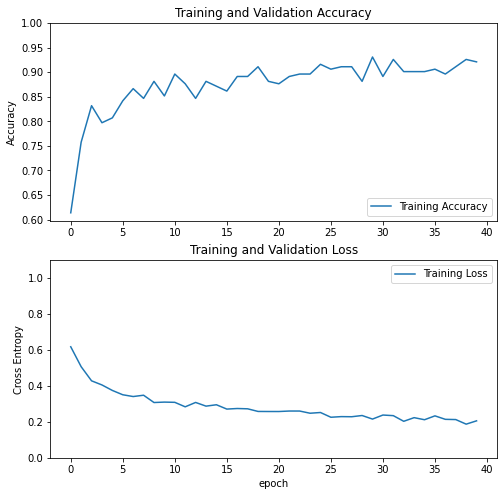

In [107]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

### Un-freeze the top layers of the model


In [108]:
base_model.trainable = True

In [109]:
print("Number of layers in the base model: ", len(base_model.layers))

## Fine-tune from this layer onwards
#fine_tune_at = 100

## Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#  layer.trainable =  False

Number of layers in the base model:  813


### compiling the model

In [110]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [111]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_2 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 2560)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0   

In [112]:
len(model.trainable_variables)

711

### continue training the model

In [113]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=[early_stopping])

Epoch 40/350
13/13 [==============================] - 58s 1s/step - loss: 0.8246 - accuracy: 0.7896
Epoch 41/350
13/13 [==============================] - 13s 1000ms/step - loss: 0.4023 - accuracy: 0.8366
Epoch 42/350
13/13 [==============================] - 13s 993ms/step - loss: 0.2350 - accuracy: 0.9059
Epoch 43/350
13/13 [==============================] - 13s 993ms/step - loss: 0.1034 - accuracy: 0.9703
Epoch 44/350
13/13 [==============================] - 13s 986ms/step - loss: 0.1128 - accuracy: 0.9554
Epoch 45/350
13/13 [==============================] - 13s 983ms/step - loss: 0.0296 - accuracy: 0.9901
Epoch 46/350
13/13 [==============================] - 13s 977ms/step - loss: 0.0460 - accuracy: 0.9901
Epoch 47/350
13/13 [==============================] - 13s 986ms/step - loss: 0.0790 - accuracy: 0.9802
Epoch 48/350
13/13 [==============================] - 13s 987ms/step - loss: 0.0313 - accuracy: 0.9950
Epoch 49/350
13/13 [==============================] - 13s 978ms/step - loss

In [114]:
# Save the weights
model.save_weights('/content/drive/MyDrive/Dataset_2/final_dataset/weights/transfer_learning_dataset1')

In [115]:
acc += history_fine.history['accuracy']

loss += history_fine.history['loss']

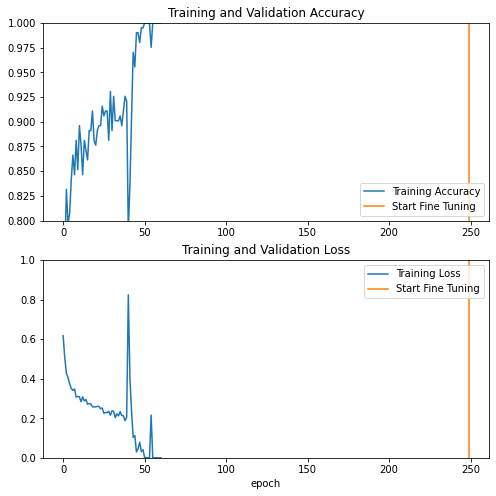

In [116]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediction

In [117]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 6s 398ms/step - loss: 0.3516 - accuracy: 0.9412
Test accuracy : 0.9411764740943909


Predictions:
 [1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1]
Labels:
 [1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1]


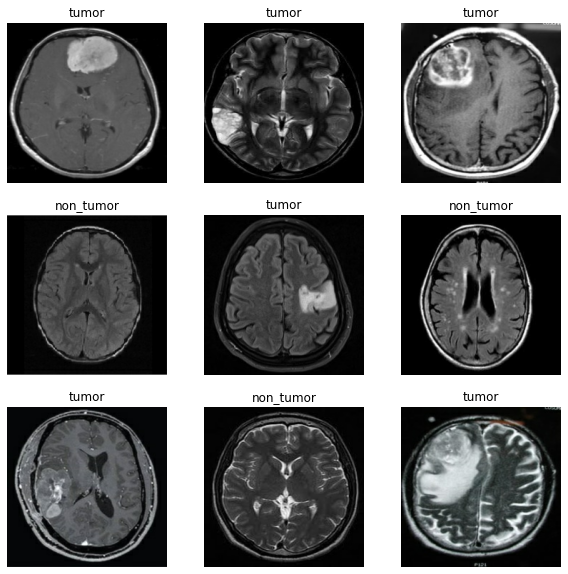

In [118]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")